# Multiclass Classification of News Articles

In this notebook, we build a binary text classifier to classify movie reviews as either positive or negative using [BERT](https://arxiv.org/abs/1810.04805), a pretrained NLP model that can be used for transfer learning on text data.  We will use the [*ktrain* library](https://github.com/amaiya/ktrain), a lightweight wrapper around Keras to help train (and deploy) neural networks.  For more information on *ktrain*, see [this Medium post](https://towardsdatascience.com/ktrain-a-lightweight-wrapper-for-keras-to-help-train-neural-networks-82851ba889c).

We will begin by installing *ktrain* and importing the required *ktrain* modules.

## Installations and imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# To allow interactive plot.

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense,Embedding,SpatialDropout1D,LSTM,Bidirectional,Conv2D,Flatten
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras import metrics
from keras import optimizers

!pip install ktrain
import ktrain
from ktrain import text

%matplotlib inline

Using TensorFlow backend.


using Keras version: 2.2.4


### Mount Google Drive, where the files are stored

### Next, we will fetch and extract the news dataset.

**This news set has 10 domains equally represented, with one domain in each newstype set aside as a test set**

In [1]:
newstypes=['fake',
 'conspiracy',
 'political',
 'junksci',
 'unreliable',
 'bias',
 'hate',
 'reliable',
 'satire',
 'clickbait']
filepath='balanced domains/'


In [3]:
#Training dataset consisting of 500 articles from 9 domains each
train=pd.read_csv(filepath+'domain_fake')
for news in newstypes[1:]:
  train2=pd.read_csv(filepath+'domain_'+news)
  print(f'{news} has shape of {train2.shape}')
  train=pd.concat([train2,train],axis=0)

#Test dataset consisting of 500 articles from 1 domain each
test=pd.read_csv(filepath+'test_fake')
for news in newstypes[1:]:
  test2=pd.read_csv(filepath+'test_'+news)
  test=pd.concat([test2,test],axis=0)  

conspiracy has shape of (4500, 15)
political has shape of (4500, 15)
junksci has shape of (4500, 15)
unreliable has shape of (4500, 15)
bias has shape of (4500, 15)
hate has shape of (4500, 15)
reliable has shape of (4500, 15)
satire has shape of (4500, 15)
clickbait has shape of (4500, 15)


In [4]:
train.shape

(45000, 15)

In [5]:
test.shape

(5000, 15)

## STEP 1:  Load and Preprocess the Dataset

The `texts_from_folder` function will load the training and validation data from the specified folder and automatically preprocess it according to BERT's requirements.  In doing so, the BERT model and vocabulary will be automatically downloaded.

In [8]:
train[newstypes].sum()

fake          4500
conspiracy    4500
political     4500
junksci       4500
unreliable    4500
bias          4500
hate          4500
reliable      4500
satire        4500
clickbait     4500
dtype: int64

### Preprocess the text using bert

In [9]:
(x_train, y_train), (x_val, y_val), preproc=text.texts_from_df(train_df=train,
                                                                 text_column='content',
                                                                 label_columns=newstypes,
                                                                 maxlen=128,
                                                                 preprocess_mode='bert',
                                                                  val_pct=0.1)

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


preprocessing test...
language: en


In [10]:
(x_test, y_test), (x_test2, y_test2), preproc=text.texts_from_df(train_df=test,
                                                                 val_df=test,
                                                                 text_column='content',
                                                                 label_columns=newstypes,
                                                                 maxlen=128,
                                                                 preprocess_mode='bert')

preprocessing train...
language: en


preprocessing test...
language: en


## STEP 2:  Load a pretrained BERT model and wrap it in a `ktrain.Learner` object

This step can be condensed into a single line of code, but we execute it as two lines for clarity. (You can ignore the deprecation warnings arising from Keras 2.2.4 with TensorFlow 1.14.0.)  

In [11]:
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc)
learner = ktrain.get_learner(model,train_data=(x_train, y_train), val_data=(x_val, y_val), batch_size=8,)

Is Multi-Label? False
maxlen is 128
done.


## STEP 3:  Fake News 

We employ the `learner.fit_onecycle` method in *ktrain* that employs the use of a [1cycle learning  rate schedule](https://arxiv.org/pdf/1803.09820.pdf).  We use a learning rate of 2e-5 based on recommendations from [the original paper](https://arxiv.org/abs/1810.04805).

As can be seen, we achieve a **93.92% validation accuracy** in a single epoch.

In [12]:
learner.fit_onecycle(2e-5, 1,checkpoint_folder='/content/drive/My Drive/Capstone_DSI/')



begin training using onecycle policy with max lr of 2e-05...
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500 [==============================] - 2773s 68ms/step - loss: 1.1950 - acc: 0.6008 - val_loss: 0.7991 - val_acc: 0.7311


Since it does not appear we are overfitting yet, we could train for an additional epoch or two for even higher accuracy.  

Feel free to try it out on your own.

In [0]:
#model.load_weights("/content/drive/My Drive/Capstone_DSI/Multiclass Checkpoints/weights-01.hdf5")

In [18]:
cm=(learner.validate(val_data=(x_val, y_val), class_names=newstypes))

              precision    recall  f1-score   support

        fake       0.70      0.67      0.69       449
  conspiracy       0.83      0.77      0.80       433
   political       0.49      0.65      0.56       453
     junksci       0.78      0.89      0.83       447
  unreliable       0.64      0.71      0.67       468
        bias       0.76      0.57      0.65       451
        hate       0.73      0.70      0.71       445
    reliable       0.91      0.84      0.87       460
      satire       0.86      0.81      0.83       445
   clickbait       0.72      0.70      0.71       449

    accuracy                           0.73      4500
   macro avg       0.74      0.73      0.73      4500
weighted avg       0.74      0.73      0.73      4500



In [23]:
cm=pd.DataFrame(cm/500,columns=[('Predicted '+str(x)) for x in newstypes],index=[('Real '+str(x)) for x in newstypes])
cm

,Predicted fake,Predicted conspiracy,Predicted political,Predicted junksci,Predicted unreliable,Predicted bias,Predicted hate,Predicted reliable,Predicted satire,Predicted clickbait
Real fake,0.602,0.016,0.064,0.018,0.064,0.020,0.060,0.000,0.006,0.048
Real conspiracy,0.018,0.668,0.034,0.042,0.038,0.024,0.016,0.004,0.004,0.018
Real political,0.040,0.028,0.586,0.028,0.034,0.038,0.040,0.046,0.028,0.038
Real junksci,0.006,0.020,0.010,0.794,0.020,0.006,0.010,0.000,0.010,0.018
Real unreliable,0.058,0.020,0.040,0.026,0.662,0.034,0.038,0.002,0.016,0.040
Real bias,0.034,0.024,0.190,0.008,0.052,0.518,0.026,0.006,0.014,0.030
Real hate,0.032,0.012,0.072,0.018,0.070,0.022,0.622,0.004,0.012,0.026
Real reliable,0.004,0.004,0.088,0.010,0.014,0.002,0.004,0.776,0.006,0.012
Real satire,0.018,0.002,0.038,0.036,0.026,0.006,0.016,0.012,0.720,0.016
Real clickbait,0.044,0.010,0.062,0.040,0.050,0.012,0.022,0.004,0.022,0.632


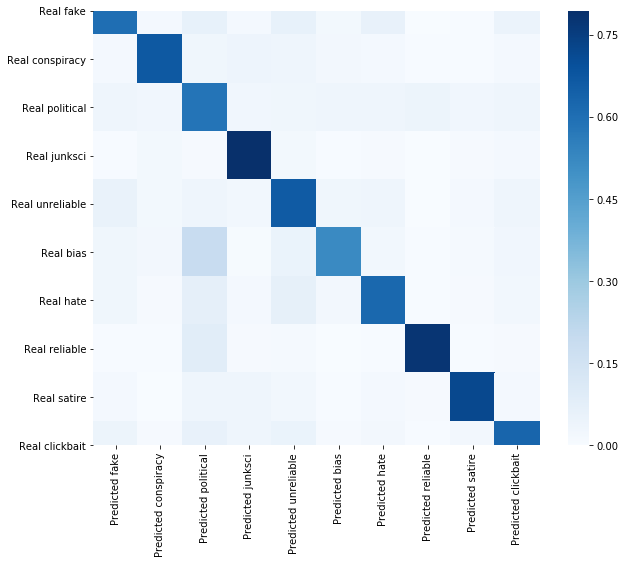

In [28]:
plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap="Blues")

In [29]:
cm2=(learner.validate(val_data=(x_test, y_test), class_names=newstypes))

              precision    recall  f1-score   support

        fake       0.13      0.09      0.11       500
  conspiracy       0.29      0.22      0.25       500
   political       0.19      0.32      0.24       500
     junksci       0.66      0.80      0.72       500
  unreliable       0.20      0.15      0.17       500
        bias       0.26      0.14      0.19       500
        hate       0.53      0.64      0.58       500
    reliable       0.77      0.64      0.70       500
      satire       0.37      0.41      0.39       500
   clickbait       0.37      0.44      0.41       500

    accuracy                           0.39      5000
   macro avg       0.38      0.39      0.37      5000
weighted avg       0.38      0.39      0.37      5000



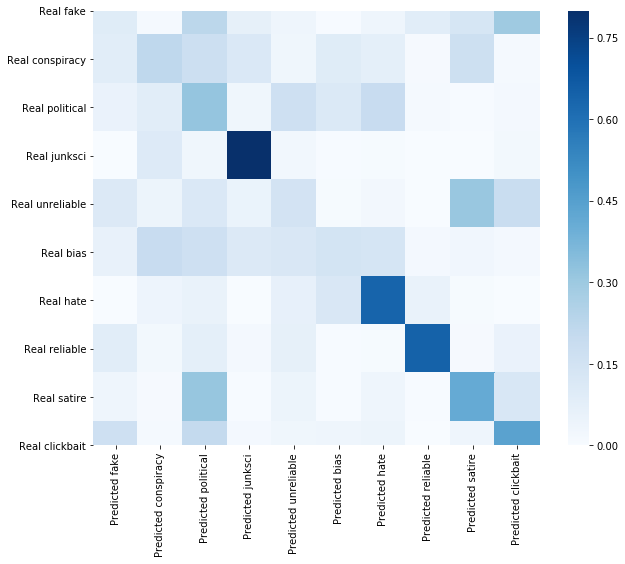

In [34]:
cm2=pd.DataFrame(cm2/500,columns=[('Predicted '+str(x)) for x in newstypes],index=[('Real '+str(x)) for x in newstypes])
plt.figure(figsize=(10,8))
sns.heatmap(cm2, cmap="Blues")

In [35]:
cm2

,Predicted fake,Predicted conspiracy,Predicted political,Predicted junksci,Predicted unreliable,Predicted bias,Predicted hate,Predicted reliable,Predicted satire,Predicted clickbait
Real fake,0.094,0.014,0.226,0.070,0.036,0.004,0.036,0.088,0.134,0.298
Real conspiracy,0.088,0.218,0.176,0.116,0.034,0.094,0.078,0.012,0.170,0.014
Real political,0.054,0.088,0.316,0.032,0.168,0.114,0.192,0.014,0.006,0.016
Real junksci,0.000,0.104,0.034,0.800,0.026,0.004,0.008,0.002,0.002,0.020
Real unreliable,0.110,0.044,0.116,0.050,0.148,0.008,0.024,0.000,0.312,0.188
Real bias,0.062,0.192,0.166,0.110,0.122,0.144,0.140,0.016,0.030,0.018
Real hate,0.000,0.042,0.058,0.002,0.066,0.124,0.640,0.058,0.008,0.002
Real reliable,0.090,0.020,0.076,0.018,0.070,0.006,0.008,0.644,0.012,0.056
Real satire,0.038,0.010,0.314,0.006,0.044,0.006,0.036,0.004,0.414,0.128
Real clickbait,0.166,0.014,0.204,0.016,0.034,0.040,0.044,0.000,0.040,0.442


In [0]:
df=pd.DataFrame(cm2/25000,columns=[('Predicted '+str(x)) for x in newstypes],index=[('Real '+str(x)) for x in newstypes])

In [31]:
sumTP=[]
sumPrecision=[]
sumRecall=[]
for n,news in enumerate(newstypes):
  TP=df.iloc[n,n]
  sumTP.append(TP)
  FP=df.iloc[n,0:].sum()-TP
  FN=df.iloc[0:,n].sum()-TP
  
  
  Precision=TP / (TP + FP)
  Recall=TP/(TP+FN)
  sumPrecision.append(Precision)
  sumRecall.append(Recall)
  #print(f'For {news} Precision: {Precision} Recall: {Recall}')

outdf=pd.DataFrame()
outdf['Newstypes']=newstypes
outdf['Precision']=sumPrecision
outdf['Recall']=sumRecall

Accuracy=np.sum(sumTP)/60000
print(f'Overall Accuracy: {Accuracy}')

Overall Accuracy: 1.2866666666666665e-06
